# Plotting spatial results from Pastas models for different wells in Bangkok, Thailand.

- A well nest may have 1-4 wells
- Outputs: Spatial maps
- Requires: previously created Pastas models

Article Title: Hybrid data-driven, physics-based modeling of ground-
water and subsidence with application to Bangkok, Thailand

Jenny Soonthornrangsan 2023
TU Delft

In [1]:
###############################################################################
# Installing packages on colab
###############################################################################
!pip install pastas
!pip install "basemap == 1.3.2" "basemap-data == 1.3.2" 
!pip install "basemap-data-hires == 1.3.2"
!pip install "matplotlib == 3.5.2"
!pip install mycolorpy
!pip install xlrd
!git clone https://github.com/jsoontho/BKKSubPastasModels.git
    
# Changing current directory to location of python script
%cd '/content/BKKSubPastasModels'

!git pull

  Using cached basemap-1.3.2.zip (155 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


  error: subprocess-exited-with-error
  
  pip subprocess to install build dependencies did not run successfully.
  exit code: 1
  
  [10 lines of output]
  Ignoring numpy: markers 'python_version == "2.7" or (python_version >= "3.4" and python_version <= "3.9")' don't match your environment
  Ignoring numpy: markers 'python_version == "2.6" or (python_version >= "3.2" and python_version <= "3.3")' don't match your environment
  Ignoring cython: markers 'python_version == "3.2"' don't match your environment
    Using cached setuptools-70.0.0-py3-none-any.whl.metadata (5.9 kB)
    Using cached wheel-0.43.0-py3-none-any.whl.metadata (2.2 kB)
  ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
  ERROR: Could not find a version that satisfies the requirement numpy==1.21.4 (from version

  Using cached matplotlib-3.5.2.tar.gz (35.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for matplotlib
Failed to build matplotlib


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [600 lines of output]
  
  Edit mplsetup.cfg to change the build options; suppress output with --quiet.
  
  BUILDING MATPLOTLIB
        python: yes [3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023,
                    13:26:23) [MSC v.1916 64 bit (AMD64)]]
      platform: yes [win32]
         tests: no  [skipping due to configuration]
        macosx: no  [Mac OS-X only]
  
  C:\Users\jtsoonthornran\Anaconda3\Lib\site-packages\setuptools\__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
  !!
  
          ********************************************************************************
          Requirements should be satisfied by a PEP 517 installer.
          If you are using pip, you can try `pip install --use-pep517`.
          ********************************************************************************
  
  !!

[WinError 3] The system cannot find the path specified: "'/content/BKKSubPastasModels'"
C:\Users\jtsoonthornran\BKKSubPastasModels\JupyterNotebooks


fatal: destination path 'BKKSubPastasModels' already exists and is not an empty directory.
There is no tracking information for the current branch.
Please specify which branch you want to merge with.
See git-pull(1) for details.

    git pull <remote> <branch>

If you wish to set tracking information for this branch you can do so with:

    git branch --set-upstream-to=origin/<branch> main



__Note that if imports don't work. Check results from cell above and click `Restart Runtime.` Then rerun cells below (including import cell)__

In [2]:
###############################################################################
# import statements
###############################################################################

# Importing packages and libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pastas as ps
import os
from mpl_toolkits.basemap import Basemap

# Changing current directory to location of main directory
%cd "C:\Users\jtsoonthornran\BKKSubPastasModels"

import bkk_sub_gw

# Importing script for pre-processing Thai GW data
import main_functions as mfs

C:\Users\jtsoonthornran\BKKSubPastasModels


In [3]:
###############################################################################
# Plotting settings
###############################################################################
plt.rc('font', size=12)  # controls default text size
plt.rc('axes', titlesize=10)  # fontsize of the title
plt.rc('axes', labelsize=8)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=8)  # fontsize of the x tick labels
plt.rc('ytick', labelsize=8)  # fontsize of the y tick labels
plt.rc('legend', fontsize=6)  # fontsize of the legend

In [4]:
# %% Importing Pastas

###############################################################################
# Pastas settings
###############################################################################

# Folder to save graph and import model
model_path = os.path.abspath("models")
fig_path = os.path.abspath("figures")

# Model files
modelfiles = os.listdir(model_path)

# Getting a list of all the wells
# Total path
tot_path = os.path.abspath("inputs")

files = os.listdir(tot_path)
files = [i.replace(".xlsx", "") for i in files
         if i.startswith("LC") and "_" not in i]

# Preallocation
# Saving RMSE values for time period
rmse = []

# model time period
time_min = "1978"
time_max = "2020"

# step response tmax
res_tmax = []

# Range of obs
obs_range = []

# Creating subsets of wells that fit certain criteria
subset_well_dict = {}

###############################################################################
# Pastas Import
###############################################################################

# For each well nest
for Wellnest_name in files:

    # Reading in groundwater data
    full_path = os.path.join(tot_path, Wellnest_name + ".xlsx")
    data = pd.read_excel(full_path, skiprows=3)

    # For all wells in well nest
    for wells in data.columns[-(len(data.columns)-2):]:

        # Well name in as a string
        well_name = wells

        # Saving well nest and well name association
        subset_well_dict[well_name] = [Wellnest_name]

        # If model file exists:
        try:
            wellmodel = [s for s in modelfiles
                         if np.logical_and(Wellnest_name in s, well_name in s)][0]
            model = ps.io.load(model_path + "/" + wellmodel)

            # If does not exist
        except FileNotFoundError:
            print("No model for " + Wellnest_name + "_" + well_name)
            continue

        # Saving rmse
        rmse_ = model.stats.rmse(tmin=time_min, tmax=time_max)

        # Saving rmse
        rmse.append(Wellnest_name)
        rmse.extend((well_name, rmse_))

        # Saving pumping step response tmax
        res_tmax.append(Wellnest_name)
        res_tmax.extend((well_name, model.get_response_tmax("well",
                                                            cutoff=0.90)/365))

        # Saving range of obs for each model
        obs_range.append(Wellnest_name)
        obs_range.extend((well_name, model.observations(
            tmin=time_min, tmax=time_max).max() - model.observations(
                tmin=time_min, tmax=time_max).min()))

# Obs range
# Overall
overall_range = np.mean(obs_range[2::3])
# BK PD NL NB Range
temp_BKrange = []
temp_PDrange = []
temp_NLrange = []
temp_NBrange = []

for i, j in enumerate(obs_range[1::3]):

    if "BK" in j:
        temp_BKrange.append(obs_range[2::3][i])

    elif "PD" in j:
        temp_PDrange.append(obs_range[2::3][i])

    elif "NL" in j:
        temp_NLrange.append(obs_range[2::3][i])

    elif "NB" in j:
        temp_NBrange.append(obs_range[2::3][i])

BK_range = np.mean(temp_BKrange)
PD_range = np.mean(temp_PDrange)
NL_range = np.mean(temp_NLrange)
NB_range = np.mean(temp_NBrange)

# RMSE
# Overall
overall_rmse = np.mean(rmse[2::3])
# BK PD NL NB Range
temp_BKrmse = []
temp_PDrmse = []
temp_NLrmse = []
temp_NBrmse = []

for i, j in enumerate(rmse[1::3]):

    if "BK" in j:
        temp_BKrmse.append(rmse[2::3][i])

    elif "PD" in j:
        temp_PDrmse.append(rmse[2::3][i])

    elif "NL" in j:
        temp_NLrmse.append(rmse[2::3][i])

    elif "NB" in j:
        temp_NBrmse.append(rmse[2::3][i])

BK_rmse = np.mean(temp_BKrmse)
PD_rmse = np.mean(temp_PDrmse)
NL_rmse = np.mean(temp_NLrmse)
NB_rmse = np.mean(temp_NBrmse)

INFO: Time Series 'Head': 19 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK003_NB27_GW_1978_2005_model.pas successfully loaded. This file was created with Pastas 1.3.0. Your current version of Pastas is: 1.3.0
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series 'Head': 13 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK003_BK2_GW_1978_2005_model.pas successfully loaded. This file was created with Pastas 1.3.0. Your current version of Pastas is: 1.3.0
INFO: Time Series 'Pump' was extended in the past to 1948-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series 'Head': 39 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK003_PD17_GW_1978_2005_model.pas successfully load

INFO: Time Series Pump was extended in the past to 1920-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series Head: 11 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK015_NB42_GW_1989_2020_model.pas successfully loaded. This file was created with Pastas 1.0.1. Your current version of Pastas is: 1.0.1
INFO: Time Series Pump was extended in the past to 1920-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series Head: 9 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK016_NL58_GW_1989_2021_model.pas successfully loaded. This file was created with Pastas 1.0.1. Your current version of Pastas is: 1.0.1
INFO: Time Series Pump was extended in the past to 1920-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series Head: 7 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornra

INFO: Time Series Pump was extended in the past to 1920-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series Head: 50 nan-value(s) was/were found and filled with: drop.
INFO: Time Series Head: User-defined option for fill_before 'None' is not supported.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK036_NB_JICA5_GW_1997_2020_model.pas successfully loaded. This file was created with Pastas 1.0.1. Your current version of Pastas is: 1.0.1
INFO: Time Series Pump was extended in the past to 1920-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series Head: 50 nan-value(s) was/were found and filled with: drop.
INFO: Time Series Head: User-defined option for fill_before 'None' is not supported.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCBKK036_NL_JICA6_GW_1997_2020_model.pas successfully loaded. This file was created with Pastas 1.0.1. Your current version of Pastas is: 1.0.1
INFO: Time Series Pump was extended in the

INFO: Time Series Pump was extended in the past to 1920-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series Head: 19 nan-value(s) was/were found and filled with: drop.
INFO: Time Series Head: User-defined option for fill_before 'None' is not supported.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCNBI007_PD56_GW_1991_2021_model.pas successfully loaded. This file was created with Pastas 1.0.1. Your current version of Pastas is: 1.0.1
INFO: Time Series Pump was extended in the past to 1920-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series Head: 2 nan-value(s) was/were found and filled with: drop.
INFO: Pastas Model from file C:\Users\jtsoonthornran\BKKSubPastasModels\models/LCNBI007_NB63_GW_1990_2021_model.pas successfully loaded. This file was created with Pastas 1.0.1. Your current version of Pastas is: 1.0.1
INFO: Time Series Pump was extended in the past to 1920-01-09 00:00:00 by adding 0.0 values.
INFO: Time Series Head: 12 nan-value(s) was

## RMSE Plotting
- Output: One graph, 2D plot with color indicator of RMSE for all 4 aq
- Figure 9 in _Groundwater_ paper

3.53m RMSE for NB
3.23m RMSE for NL
2.00m RMSE for PD
1.56m RMSE for BK
Average RMSE for all four aquifers: 2.83m


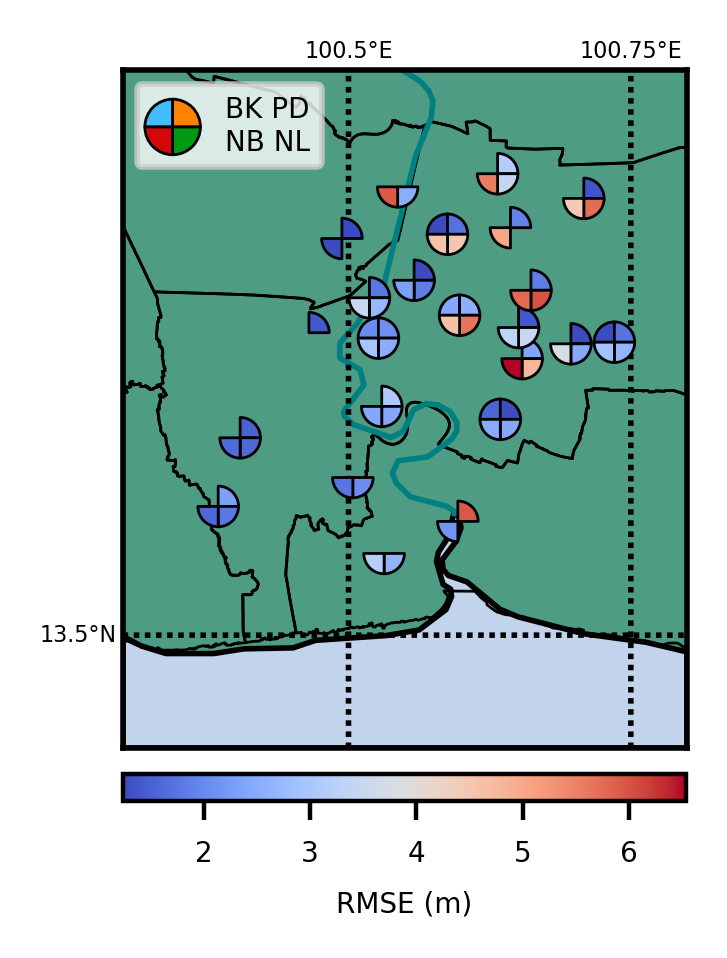

In [5]:
# Importing spatial coordinates
full_path = os.path.join(tot_path, "GroundwaterWellLocs.xls")
gwwell_locs = pd.read_excel(full_path)

# Locations of wellnests removing duplicates
gwwell_locs = gwwell_locs.drop_duplicates("WellNest_Name", keep="first")

# Aquifer of interest
aqs = ["BK", "PD", "NL", "NB"]

# Preallocation
# Empty dictionary
d_dict = {}

# For each aquifer of interest
for aq in aqs:

    # Preallocation
    # Saving relevant xs, ys, and rmse
    xs = []
    ys = []
    cs = []

    # Subsets of the RMSE data, and list of wellnest names
    well_data = []
    wellnest_list = []

    # Extracting relavent data
    # Going through each rmse saved
    for i in rmse:

        # If string ie if the well nest or aquifer name
        if isinstance(i, str):

            # If the aquifer anem
            if i.startswith(aq):

                # Saving well nest name, well name, and rmse
                well_data.extend([rmse[rmse.index(i)-1],
                                  rmse[rmse.index(i)],
                                  rmse[rmse.index(i)+1]])
                wellnest_list.extend([rmse[rmse.index(i)-1]])

    # Unique well nests and locations only
    unique = []

    # Getting rid of repeating wells and data points
    # zip joins x and y coordinates in pairs
    for x, y in zip(gwwell_locs.Long, gwwell_locs.Lat):

        # Check if x, y is unique
        if (x, y) not in unique:

            # Saves this location for plotting
            unique.append((x, y))

            # Label is well nest name
            label = gwwell_locs.loc[
                gwwell_locs.Long == x]["WellNest_Name"].tolist()
            # Specific well nest does not have a well in the aquifer
            if label[0] not in wellnest_list:
                continue

            # If well nest has a well in the aquifer
            else:

                # Saving loc data
                xs.append(x)
                ys.append(y)

                # Saving RMSE
                cs.append(well_data[well_data.index(label[0])+2])

    # Creates a dictionary with location and relative RMSE value
    d_dict[aq] = pd.DataFrame({"x": xs, "y": ys, "cs": cs})

# Initializing figure
fig, ax = plt.subplots(figsize=(3.2, 2.2), dpi=400)

# Plotting settings
# Setting the same color bar limits for all four wells
data_lim = [min(np.array(cs)[~mfs.is_outlier(cs, 3.5)]),
            max(np.array(cs)[~mfs.is_outlier(cs, 3.5)])]

plt.set_cmap("coolwarm")  # Color map settings

# Plots
# Creating a basemap
map = Basemap(llcrnrlon=100.3, llcrnrlat=13.4, urcrnrlon=100.8, urcrnrlat=14,
              resolution="h", ellps="WGS84", lat_0=13.6, lon_0=100.4)

bkk_sub_gw.bkk_plotting.draw_basemap(map, xs, ys, d_dict, fig=fig, ax=ax,
                                     datalim=data_lim, mode="RMSE_full", save=0,
                                     aq=aq, perc=0,
                                     time_min=time_min, time_max=time_max,
                                     figpath=fig_path)

## Tmax Plotting
- Output: One spatial plot: 2D plot with color indicator of tmax for all 4 aq
- Figure 10 in _Groundwater_ paper

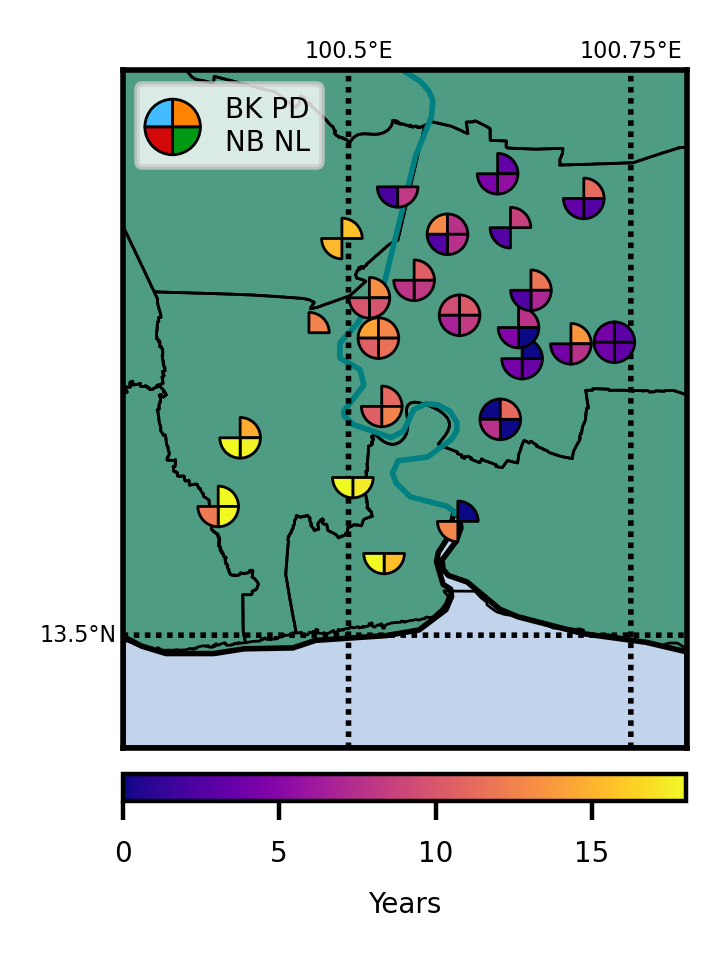

In [6]:
# Importing spatial coordinates
full_path = os.path.join(tot_path, "GroundwaterWellLocs.xls")
gwwell_locs = pd.read_excel(full_path)

# Locations of wellnests; removing duplicates
gwwell_locs = gwwell_locs.drop_duplicates("WellNest_Name", keep="first")

# Aquifer of interest
aqs = ["BK", "PD", "NL", "NB"]

# Preallocation
# Empty dictionary
d_dict = {}

# Getting data
# For each aquifer of interest
for aq in aqs:

    # Preallocation
    # Saving relevant xs, ys, and tmax
    xs = []
    ys = []
    cs = []

    # Subsets of the res_tmax data, and list of wellnest names
    well_data = []
    wellnest_list = []

    # Extracting relavent data
    # Going through each res_tmax data
    for i in res_tmax:

        # If string (well nest or aquifer name)
        if isinstance(i, str):

            # If the aquifer name
            if i.startswith(aq):

                # Saving well nest name, well name, and res_tmax
                well_data.extend([res_tmax[res_tmax.index(i)-1],
                                  res_tmax[res_tmax.index(i)],
                                  res_tmax[res_tmax.index(i)+1]])
                wellnest_list.extend([res_tmax[res_tmax.index(i)-1]])

    # Unique x, ys only
    # Dissuades if multiple well nests at the same location
    unique = []

    # Getting rid of repeating wells and data points
    # zip joins x and y coordinates in pairs
    for x, y in zip(gwwell_locs.Long, gwwell_locs.Lat):

        # Check if x, y is unique
        if (x, y) not in unique:

            # Saves location for plotting
            unique.append((x, y))

            # Label is well nest name
            label = gwwell_locs.loc[
                gwwell_locs.Long == x]["WellNest_Name"].tolist()

            # Specific well nest does not have a well in the aquifer
            if label[0] not in wellnest_list:
                continue

            # If well nest has a well in the aquifer
            else:

                # Saving data
                xs.append(x)
                ys.append(y)
                cs.append(well_data[well_data.index(label[0])+2])

    # Dictionary with locations and data
    d_dict[aq] = pd.DataFrame({"x": xs, "y": ys, "cs": cs})

# Plot settings
# Initializing figure
fig, ax = plt.subplots(figsize=(3.2, 2.2), dpi=400)

# Setting the same color bar limits for all four wells
data_temp = [e for e in res_tmax if isinstance(e, float)]
data_lim = [min(np.array(data_temp)[~mfs.is_outlier(data_temp, 3.5)]),
            max(np.array(data_temp)[~mfs.is_outlier(data_temp, 3.5)])]
data_lim = [0, 18]

plt.set_cmap("plasma")  # Color map colors

# Plots
map = Basemap(llcrnrlon=100.3, llcrnrlat=13.4, urcrnrlon=100.8, urcrnrlat=14,
              resolution="h", ellps="WGS84", lat_0=13.6, lon_0=100.4)
bkk_sub_gw.bkk_plotting.draw_basemap(map, xs, ys, d_dict, fig=fig, ax=ax,
                                     datalim=data_lim, mode="step_full", save=0,
                                     aq=aq, perc=0,
                                     time_min=time_min, time_max=time_max,
                                     figpath=fig_path)